# Image Viewer

So this code adds indexes to both dropdown lists and carents for cancer patients in the dicom files and astericks for cancer patients in the LUNA16 dropdown list.  I will also be committing a little more code to circle the malignant nodules in the LUNA16 data set, and will likely display the slice number where the malignant tumors are located.  The real-world x, y, and z coordinates along with the diameter (all measured in mm) of the malignant cells are found in the annotations csv file included in the LUNA16 data collection.  Feel free to commit any changes that makes this image viewer faster.  

An important note about the annotations.csv is that the coordinates and diameter in this file are in millimeters (I'm pretty sure) and need to be converted into voxel (3D pixels) spacing depending on the spacing of each LUNA16 patients CT scan calibration so we can circle the nodule.  I'll be adding comments in the code, but it's important to keep the structure of the image array, and the structure of sitk.GetOrigin() and sitk.GetSpacing() lists in check so we're dividing and subtracting correctly.  It will all make sense in my comments, but it was frustrating to find hard documentation on how numpy arrays, and SimpleITK, ordered pixels/the ct origin/the ct scan spacing lists:

* Numpy arrays of the CT scan have the shape displayed as [z,y,x].
* GetOrigin() command displays (x, y, z), which is the voxel origin of the CT scan.  
* GetSpacing() command displayes either (x, y, z) or (y, x, z), I'm not sure which, but I ran a loop and x was always equalled y in a small subset of the data, so I guess the order doesn't matter.

Anyway, make commits as you need to and let's try and speed this code up a little bit, if possible. One thing that irks me is how the CT scans flash whenever a new scan is selected in the image slider; it would be great if we could somehow find a way to make the images fade in and out so it's less choppy.  Good hunting!

# DICOM Image Viewer

In [ ]:
%%cmd
pip install pydicom
pip install SimpleITK

In [10]:
import os
import dicom
import SimpleITK as sitk
import numpy as np
import pandas as pd
from ipywidgets import widgets, interact, interactive, IntSlider, Layout
from IPython.display import display,clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Load list of all patients
dicom_path = 'C:/Users/572203/Documents/Data Science Bowl 2017/stage1/stage1' #Hard code the location of the stage1 data 
dicom_patients = sorted(os.listdir(dicom_path))
dicom_patients_indexlist = [str(patientindex) + ': ' for patientindex in range(0, len(dicom_patients))]#I made this list because I wanted to prepend the list of patients with their numerical id
stage1_labels = pd.read_csv('C:/Users/572203/Documents/Data Science Bowl 2017/stage1_labels.csv', header = 0) #hard code the location of your stage1_labels.csv file
stage1_cancer = []
for s in stage1_labels.cancer:
    if s == 1: 
        stage1_cancer.append(" ^ ")
    elif s == 0:
        stage1_cancer.append("")
#above: this for loop creates a list of either carets or nothing that corresponds to whether a patient in the stage1_labels csv file has cancer or not
combined_stage1_list = [x+y+z for x,y,z in zip(dicom_patients_indexlist, stage1_cancer, dicom_patients)] #this creates a list of patient ids and carets (or nothing) if they have cancer, and then the actual patient number

#Instantiate Controls
dicom_patient_list = widgets.Select(description = 'Patients',options = combined_stage1_list)  # populate the drop down with the sorted list of patients, 
    #with their appropriate index number and a ^ at the end if the patient has cancer according to the stage1_labels.csv file
dicom_img_slider = IntSlider(description = "Image Number", min = 0, value = 0) # create image slider and set min = 0; we won't know the max until a patient is selected
#play_scan = widgets.Play(min = 0,
                         #step = 1,
                         #description = "Play CT scan",
                         #disabled = False)
#The above play_scan button was an attempt to create a play button to "play" the CT scans, but we have to figure out how to slow down the playing of images so the images have enough time to render on the screen; right now the player moves too quickly
#Also, for asthetics, it would be great if the pictures would fade in and out instead of flashing like they do

In [11]:
# Function to load a patient's data
def load_dicom_patient(args = ''):
    dicom_patient_path = os.path.join(dicom_path,dicom_patients[dicom_patient_list.options.index(dicom_patient_list.value)])  #store the path to the selected patient.
    #above, within the .join(), this goofy setup ensures the patient value is grabbed, then the index of that patient within the overall dicom patient list, then that index is fed into the dicom_patients list to get the real patient number.  If someone can find a more simple method for this, please commit.
    global dicom_slices
    dicom_slices = [dicom.read_file(dicom_patient_path + '/' + s) for s in os.listdir(dicom_patient_path)] #read in the individual slices
    dicom_slices.sort(key = lambda x: int(x.ImagePositionPatient[2])) #sort slices based on vertical position
    dicom_img_slider.max = len(dicom_slices) - 1 #set the max of the image slider
    #play_scan.max = len(dicom_slices) - 1 #set the max of the play_scan widget
    plot_dicom_img()
    
def plot_dicom_img(args = ''):
    dicom_img = dicom_slices[dicom_img_slider.value].pixel_array #extract the image data from the selected slice
    clear_output(wait = True)
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(dicom_img,cmap=plt.cm.gray)
    ax.axes.axis('off')

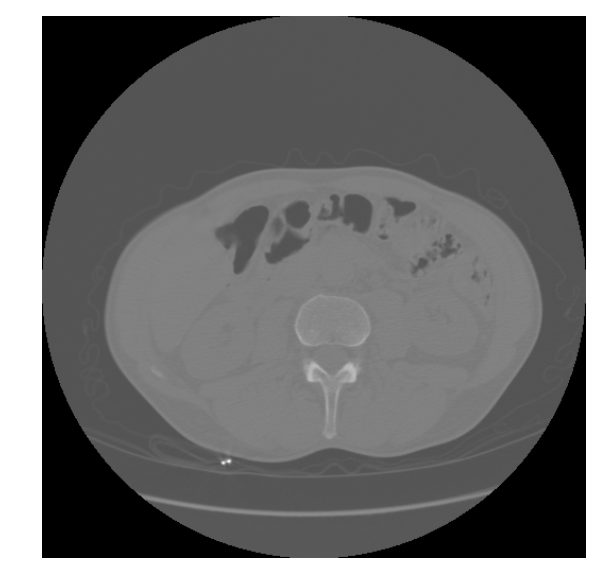

In [12]:
dicom_patient_list.observe(load_dicom_patient,'value')
#play_scan.observe(plot_dicom_img,'value')
dicom_img_slider.observe(plot_dicom_img,'value')

#widgets.jslink((play_scan, 'value'), (dicom_img_slider, 'value')) #this widget is to link the play button and the slider so the numbers correspond

display(dicom_patient_list)
#display(play_scan)
display(dicom_img_slider)

load_dicom_patient()

# RAW Image Viewer

In [11]:
import os
import dicom
import SimpleITK as sitk
import numpy as np
import pandas as pd
from ipywidgets import widgets, interact, interactive, IntSlider
from IPython.display import display,clear_output
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline

raw_path = 'C:/Users/572203/Documents/Data Science Bowl 2017/LUNA16/subset0/subset0' #Hard code the location of the data
all_files = os.listdir(raw_path)
raw_patients = [i for i in all_files if '.mhd' in i]
raw_patients = sorted(raw_patients)
raw_patients = [i[:-4] for i in raw_patients] #I did this to remove the ".mhd" from the end of each of the patients numbers, just an aesthetic
raw_patients_indexlist = [str(patientindex) + ': ' for patientindex in range(0, len(raw_patients))]

cancer_annotations = pd.read_csv("C:/Users/572203/Documents/Data Science Bowl 2017/LUNA16/annotations.csv", header = 0)#Hard code the location of the annotations file
cancerannotations_list = sorted(list(set(cancer_annotations['seriesuid'].tolist())))
LUNA16_cancer = []
for i in raw_patients:
    try:
        cancerannotations_list.index(i)
        LUNA16_cancer.append(" * ")
    except: 
        LUNA16_cancer.append("")

combined_raw_list = [x+y+z for x,y,z in zip(raw_patients_indexlist, LUNA16_cancer, raw_patients)]
        
raw_patient_list = widgets.Select(description = 'Patients',options = combined_raw_list)  # populate the drop down with the sorted list of patients
raw_img_slider = IntSlider(description = "Image Number", min = 0) # create image slider and set min = 0; we won't know the max until a patient is selected
cancer_labels = widgets.Label() # this is a label that will eventually get filled with the slice numbers where cancer is located

In [12]:
def get_cancer_coordinates():
    raw_spacing = raw_slices.GetSpacing()
    raw_origin = raw_slices.GetOrigin()
    if raw_patients[raw_patient_list.options.index(raw_patient_list.value)] in cancer_annotations.seriesuid.values:
        patient_annotations = cancer_annotations[cancer_annotations.seriesuid == raw_patients[raw_patient_list.options.index(raw_patient_list.value)]]
        patient_annotations_transform = patient_annotations.drop('seriesuid', axis = 1)
        patient_annotations_transform.loc[:,'coordX'] = patient_annotations_transform.loc[:,'coordX'] - raw_origin[0]
        patient_annotations_transform.loc[:,'coordY'] = patient_annotations_transform.loc[:,'coordY'] - raw_origin[1]
        patient_annotations_transform.loc[:,'coordZ'] = patient_annotations_transform.loc[:,'coordZ'] - raw_origin[2]
        patient_annotations_transform.loc[:,'coordX'] = patient_annotations_transform.loc[:,'coordX'] / raw_spacing[0]
        patient_annotations_transform.loc[:,'coordY'] = patient_annotations_transform.loc[:,'coordY'] / raw_spacing[1]
        patient_annotations_transform.loc[:,'coordZ'] = patient_annotations_transform.loc[:,'coordZ'] / raw_spacing[2]
        patient_annotations_transform.loc[:,'diameter_mm'] = patient_annotations_transform.loc[:,'diameter_mm'] / raw_spacing[0]
        patient_annotations_transform = patient_annotations_transform.apply(round, axis = 0)
        return patient_annotations_transform
    else: return pd.DataFrame()
    
    #so i dont think the above code is quite working yet, so tomorrow you should test it on one image and see if you can actually create the circle on the image, and then we'll go from there

def load_raw_patient(args = ''):
    raw_patient_path = os.path.join(raw_path,raw_patients[raw_patient_list.options.index(raw_patient_list.value)]+'.mhd')  #store the path to the selected patient
    global raw_slices, raw_slices_array
    raw_slices = sitk.ReadImage(raw_patient_path)
    raw_slices_array = sitk.GetArrayFromImage(raw_slices)
    raw_img_slider.max = len(raw_slices_array) - 1 #set the max of the image slider
    plot_raw_img()
    
def plot_raw_img(args = ''):
    raw_img = raw_slices_array[raw_img_slider.value] #extract the image data from the selected slice
    patient_annotations_transform = get_cancer_coordinates()
    clear_output(wait = True)
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(raw_img,cmap=plt.cm.gray)
    if not patient_annotations_transform.empty:
        cancer_labels.value = "Slice number(s) of malignant tumors: "+', '.join([str(i) for i in sorted([int(i) for i in patient_annotations_transform.coordZ.values])])
        if raw_img_slider.value in patient_annotations_transform.coordZ.values:
            x = patient_annotations_transform.loc[patient_annotations_transform['coordZ']==raw_img_slider.value].coordX.values
            y = patient_annotations_transform.loc[patient_annotations_transform['coordZ']==raw_img_slider.value].coordY.values
            r = np.round(patient_annotations_transform.loc[patient_annotations_transform['coordZ']==raw_img_slider.value].diameter_mm.values/2, decimals = 0)
            for xx,yy,rr in zip(x,y,r):
                circ = Circle((xx,yy), radius = (rr+4), fill = False, edgecolor = 'red')
                ax.add_patch(circ)
    else: cancer_labels.value = "This patient does not have malignant tumor cells"
    ax.axes.axis('off')

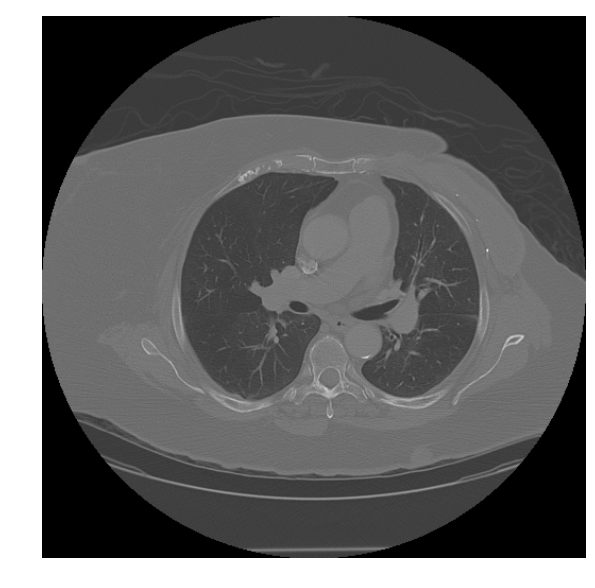

In [14]:
raw_patient_list.observe(load_raw_patient,'value')
raw_img_slider.observe(plot_raw_img,'value')

display(raw_patient_list)
display(cancer_labels)
display(raw_img_slider)

load_raw_patient()